# Симпсоны. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



---

## Идеи

Некоторые реализованы, некоторые -- нет. [X] -- реализована

<hr style="border: 1px dashed; color: gray;">


### Аугментация


[X] Хочется увеличить количество данных. Поэтому флип, ротате, (увеличения яркостей)

[ ] Сделать одинкаовое количество фоточек во всех классах через аугментации

<hr style="border: 1px dashed; color: gray;">


### Кроссвалидация

[ ] Сделать вместо разделения на train, valid, кроссвалидацию и сохранить ансамблем.


<hr style="border: 1px dashed; color: gray;">


### Модели

[X] ResNet18 с заморозкой первых слоев

[ ] ResNet с ограничением обучения первых слоев


<hr style="border: 1px dashed; color: gray;">


### Остальное

[X] AdamW

[X] lr scheduler

[X] WeightedRandomSampler поскольку несбалансированные класс


---

## Загрузка данных

(для colab)

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
# !mkdir -p ~/.kaggle
# !cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle competitions download -c journey-springfield

In [4]:
# !unzip journey-springfield.zip

---

## Работа с датасетом

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torch

import pytorch_lightning as pl

from matplotlib import colors, pyplot as plt
%matplotlib inline


Для воспроизводимости

In [2]:
import torch
import random
import numpy as np


def set_seed(seed):
    random.seed(seed)                  # Python
    np.random.seed(seed)               # Numpy
    torch.manual_seed(seed)            # PyTorch CPU
    torch.cuda.manual_seed(seed)       # PyTorch GPU
    torch.backends.cudnn.deterministic = True  # Для детерминированности на CUDA
    torch.backends.cudnn.benchmark = False     # Для воспроизводимости

set_seed(42)

In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Добавим аугментации для train к кастомному классу датасета:

- Случайный crop вместо детерминированного
- случайный поворот на 25 градусов
- случайный флип

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    # не оч хороший код, но рабочий
    def __getitem__(self, index):
      # Выбираем нужную трансформацию
      if self.mode == "train":
          transform = transforms.Compose([
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(25),
              # transforms.RandomResizedCrop(RESCALE_SIZE),
              # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

      x = self.load_sample(self.files[index])
      x = self._prepare_sample(x)  # сейчас x — numpy.ndarray
      # Преобразуем обратно в PIL.Image
      x = Image.fromarray(x)
      x = transform(x)
      # print(x)

      if self.mode == 'test':
          return x
      else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y


    def _prepare_sample(self, image):
      image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
      return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

<hr style="border: 1px dashed; color: gray;">


Будем брать данные с заданной вероятностью (по количеству картинок в датасете к общему числу) через WeightedRandomSampler

In [10]:
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

all_labels = [path.parent.name for path in train_files]
# Находим уникальные метки и их количество
unique_labels, counts = np.unique(all_labels, return_counts=True)

# Вычисляем вес для каждого класса как обратную частоту
class_weights = {label: 1.0 / count for label, count in zip(unique_labels, counts)}

# Применяем веса ко всем примерам
sample_weights = np.array([class_weights[label] for label in all_labels])

# Преобразуем в тензор
sample_weights = torch.tensor(sample_weights, dtype=torch.float)

# Создаем WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers = 4)

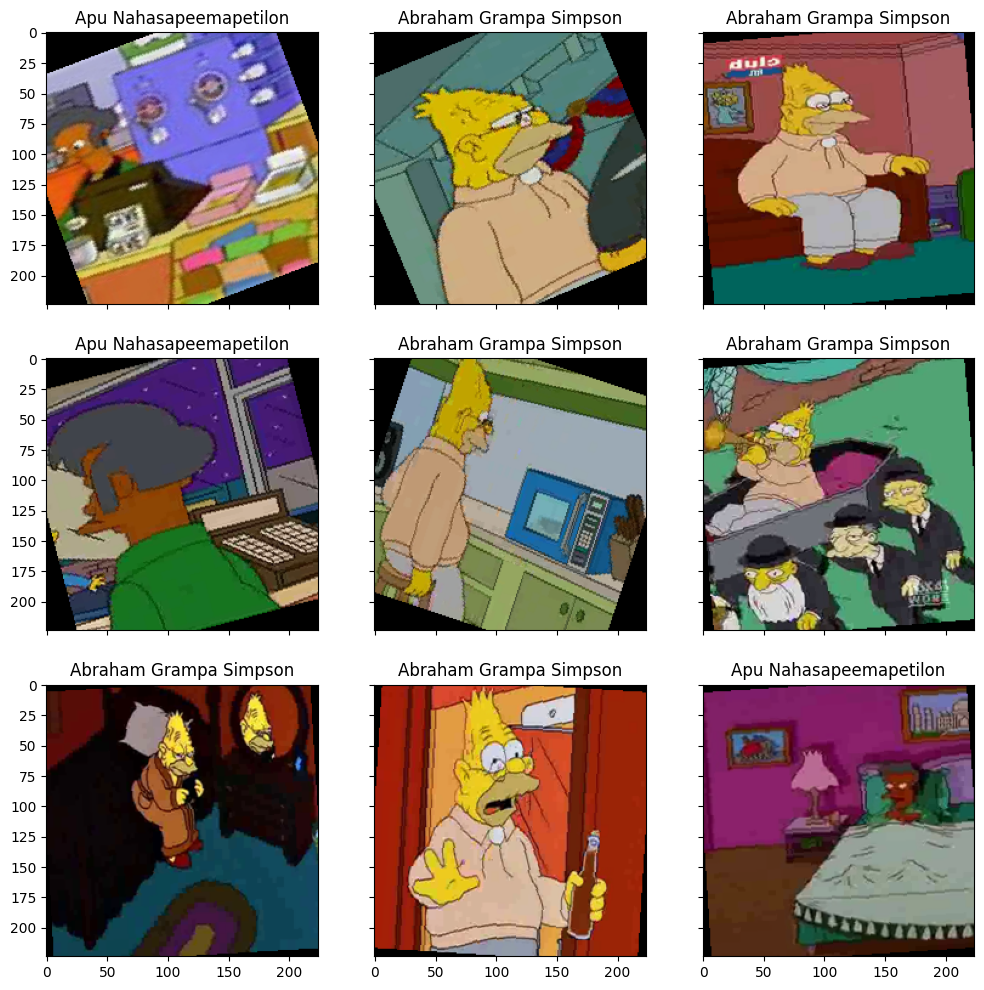

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

---

## Дополнительные функции для обучения


Будем обучать через PyTorch Lightning (реализует функционал обучения, логирования и так далее), отслеживать через TensorBoard

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics


# LightningModule, где реализована логика обучения и валидации
class LitModel(pl.LightningModule):
    def __init__(self, model, criterion, num_classes, lr=1e-3):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.lr = lr
        self.num_classes = num_classes
        
        # метрики (F1 - главная, а также Accuracy)
        self.train_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        
        self.train_f1.update(preds, y)
        self.train_acc.update(preds, y)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self, outputs = None):
        train_f1 = self.train_f1.compute()
        train_acc = self.train_acc.compute()
        # логируем F1 как главную метрику, а также accuracy
        self.log("train_f1", train_f1, prog_bar=True)
        self.log("train_acc", train_acc, prog_bar=True)
        self.train_f1.reset()
        self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        
        self.val_f1.update(preds, y)
        self.val_acc.update(preds, y)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def on_validation_epoch_end(self, outputs = None):
        val_f1 = self.val_f1.compute()
        val_acc = self.val_acc.compute()
        self.log("val_f1", val_f1, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        self.val_f1.reset()
        self.val_acc.reset()
    
    def configure_optimizers(self):
        # Формируем две группы параметров:
        # 1. С весовым распадом (для всех, кроме batch norm и bias)
        # 2. Без весового распада (batch norm и bias)
        decay, no_decay = [], []
        for name, param in self.named_parameters():
            if not param.requires_grad:
                continue
            # Если параметр является bias или принадлежит слою batch norm, не применяем weight decay
            if "bias" in name or "bn" in name or "batchnorm" in name.lower():
                no_decay.append(param)
            else:
                decay.append(param)
    
        optimizer = torch.optim.AdamW([
            {"params": decay},
            {"params": no_decay, "weight_decay": 0.0}
        ], lr=self.lr)
    
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  
                "frequency": 1,       
                "monitor": "val_loss" 
            }
        }


---

## ResNet18


Будем пробовать с resnet18. Первые слои заморозим, оставим последний слой для обучения. Напишем отдельным классом.

In [18]:
from torchvision.models import ResNet18_Weights


models.resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
class SimpsonsResNet18(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # заморозка параметров
    for param in self.base_model.parameters():
      param.requires_grad = False

    # разморозка последнего блока
    for param in self.base_model.layer4.parameters():
      param.requires_grad = True

    # замена последнего блока на нужный классификатор
    in_features = self.base_model.fc.in_features
    self.base_model.fc = nn.Linear(in_features, n_classes)


  def forward(self, x):
    return self.base_model(x)

<hr style="border: 1px dashed; color: gray;">


### Обучение

In [20]:
n_classes = len(np.unique(val_dataset.labels))

model = SimpsonsResNet18(n_classes).to(DEVICE)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
lit_model = LitModel(model=model, criterion=criterion, num_classes=n_classes, lr=1e-3)

In [23]:
%reload_ext tensorboard
%tensorboard --logdir tb_logs

<IPython.core.display.Javascript object>

Будем сохранять на каждой эпохе модель

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    monitor="val_f1",      # метрика, по которой определяется лучшая модель
    mode="max",            # режим максимизации (так как F1 нужно увеличивать)
    save_top_k=1,          # сохраняем только лучший чекпоинт
    filename="{epoch:02d}-{val_f1:.4f}"
)

In [27]:
from pytorch_lightning.loggers import TensorBoardLogger


logger = TensorBoardLogger("tb_logs", name="simpsons_res_net18")

# Создаем Trainer
trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback])

# Запускаем обучение
trainer.fit(lit_model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

---

## Загрузка результата в Kaggle

Тут я не запаривался над кодом, скопировал с референса ноутбука. Происходит просто загрузка результата

In [40]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [41]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [42]:
# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Переносим модель на устройство
model = model.to(device)

# Получаем изображение из датасета
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]

# Перемещаем изображение на то же устройство
ex_img = ex_img.unsqueeze(0).to(device)

# Предсказание
probs_im = predict_one_sample(model, ex_img)

In [43]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [44]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [45]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [47]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [48]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [51]:
my_submit.to_csv('res_net_baseline_new_sheduler.csv', index=False)

In [ ]:
torch.save(model.state_dict(), 'resnet18_weights_new_sheduler.pth')

---

## Результат

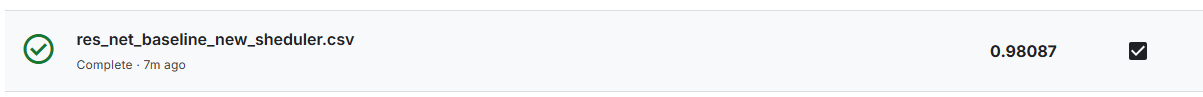

<hr style="border: 1px dashed; color: gray;">
